Imports

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

Counting number of videos in each folder

Number of Real videos: 200
Number of Fake videos: 200


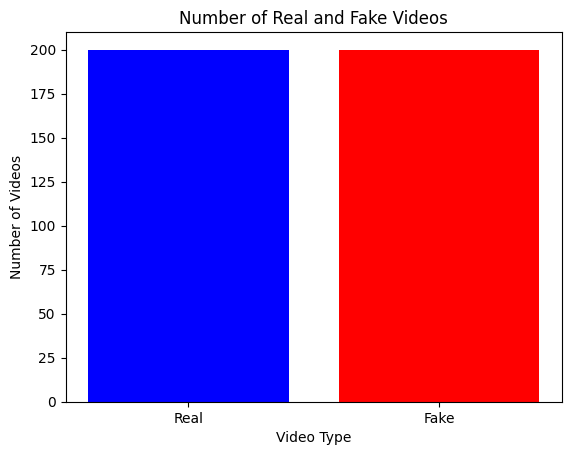

In [7]:
def count_videos(folder_path):
    files = os.listdir(folder_path)
    num_videos = 0
    for file in files:
        #Checking mp4 extension
        if file.endswith('.mp4'):
            num_videos += 1
    return num_videos
num_real_videos = count_videos('real')
num_fake_videos = count_videos('fake')
print("Number of Real videos:", num_real_videos)
print("Number of Fake videos:", num_fake_videos)

#Plotting on a bar graph
categories = ['Real', 'Fake']
counts = [num_real_videos, num_fake_videos]

plt.bar(categories, counts, color=['blue', 'red'])
plt.xlabel('Video Type')
plt.ylabel('Number of Videos')
plt.title('Number of Real and Fake Videos')
plt.show()


Lengths, Resolutions and Format

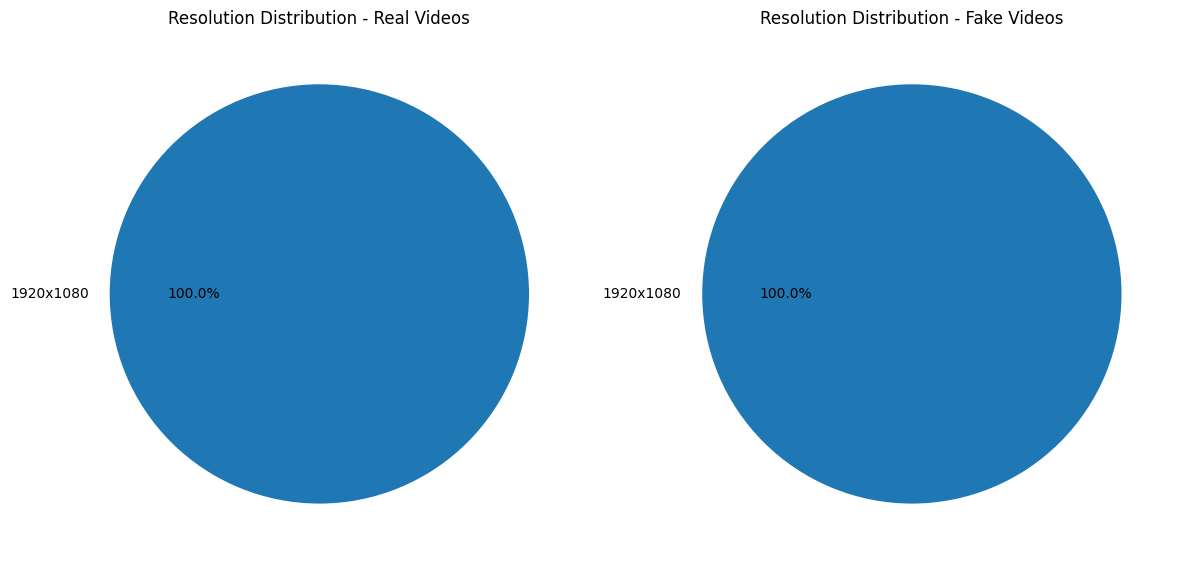

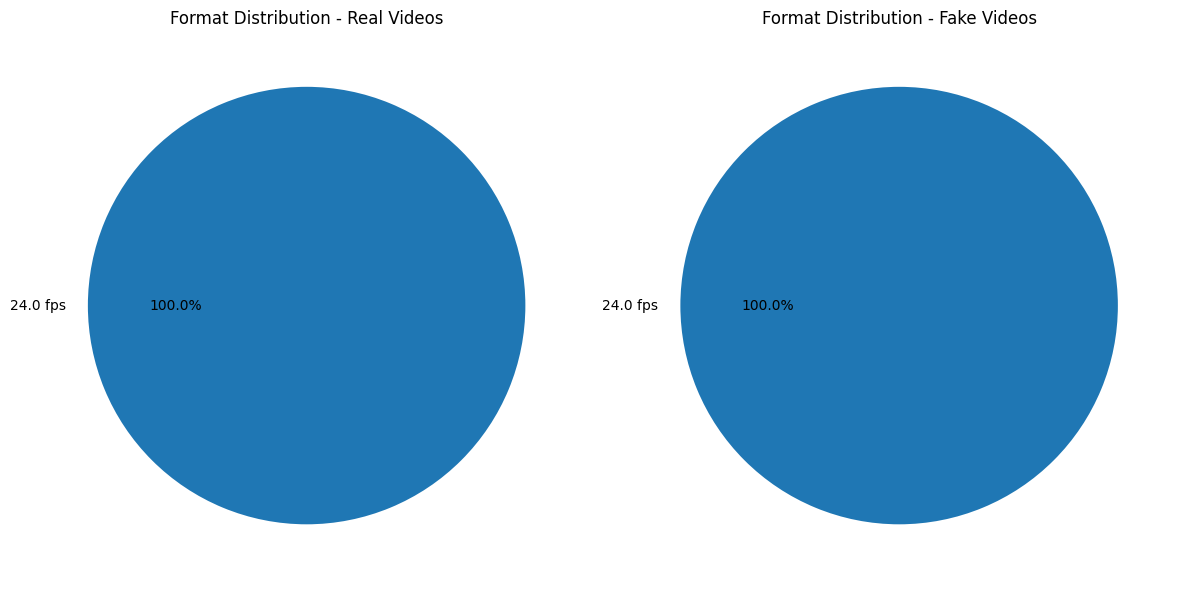

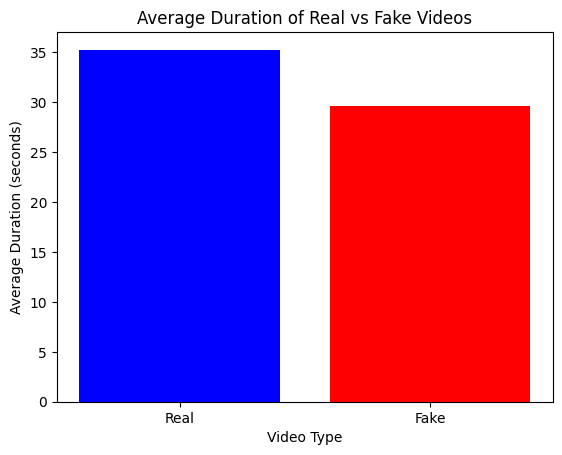

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

def get_video_info(folder_path):
    video_info = []
    resolutions = {}
    formats = {}
    
    files = os.listdir(folder_path)
    for file in files:
        if file.endswith('.mp4'):
            file_path = os.path.join(folder_path, file)
            cap = cv2.VideoCapture(file_path)
            if not cap.isOpened():
                print("Error: Could not open video file:", file)
                continue
            # Get video properties
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            duration = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / fps
            video_info.append({'File': file, 'Resolution': (width, height), 'Duration': duration, 'Format': fps})
            
            # Count resolutions
            resolution_str = f"{width}x{height}"
            resolutions[resolution_str] = resolutions.get(resolution_str, 0) + 1
            
            # Count formats
            formats[fps] = formats.get(fps, 0) + 1
            
            cap.release()
    return video_info, resolutions, formats

# Get video information, resolutions, and formats for real and fake folders
real_videos_info, real_resolutions, real_formats = get_video_info('real')
fake_videos_info, fake_resolutions, fake_formats = get_video_info('fake')

# Plotting resolutions for Real and Fake videos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(real_resolutions.values(), labels=real_resolutions.keys(), autopct='%1.1f%%')
plt.title('Resolution Distribution - Real Videos')

plt.subplot(1, 2, 2)
plt.pie(fake_resolutions.values(), labels=fake_resolutions.keys(), autopct='%1.1f%%')
plt.title('Resolution Distribution - Fake Videos')

plt.tight_layout()
plt.show()

# Plotting formats for Real and Fake videos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(real_formats.values(), labels=[f'{fps} fps' for fps in real_formats.keys()], autopct='%1.1f%%')
plt.title('Format Distribution - Real Videos')

plt.subplot(1, 2, 2)
plt.pie(fake_formats.values(), labels=[f'{fps} fps' for fps in fake_formats.keys()], autopct='%1.1f%%')
plt.title('Format Distribution - Fake Videos')

plt.tight_layout()
plt.show()

# Calculate average duration for real and fake videos
real_duration = sum(video['Duration'] for video in real_videos_info) / len(real_videos_info)
fake_duration = sum(video['Duration'] for video in fake_videos_info) / len(fake_videos_info)

# Plotting
labels = ['Real', 'Fake']
average_duration = [real_duration, fake_duration]

plt.bar(labels, average_duration, color=['blue', 'red'])
plt.xlabel('Video Type')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Duration of Real vs Fake Videos')
plt.show()


Sharpness and Color Variance. 

Sharpness is calculated using Laplacian method as shown in this answer https://stackoverflow.com/questions/28717054/calculating-sharpness-of-an-image

Color variance is calculated by applying mean to the bgr variance values

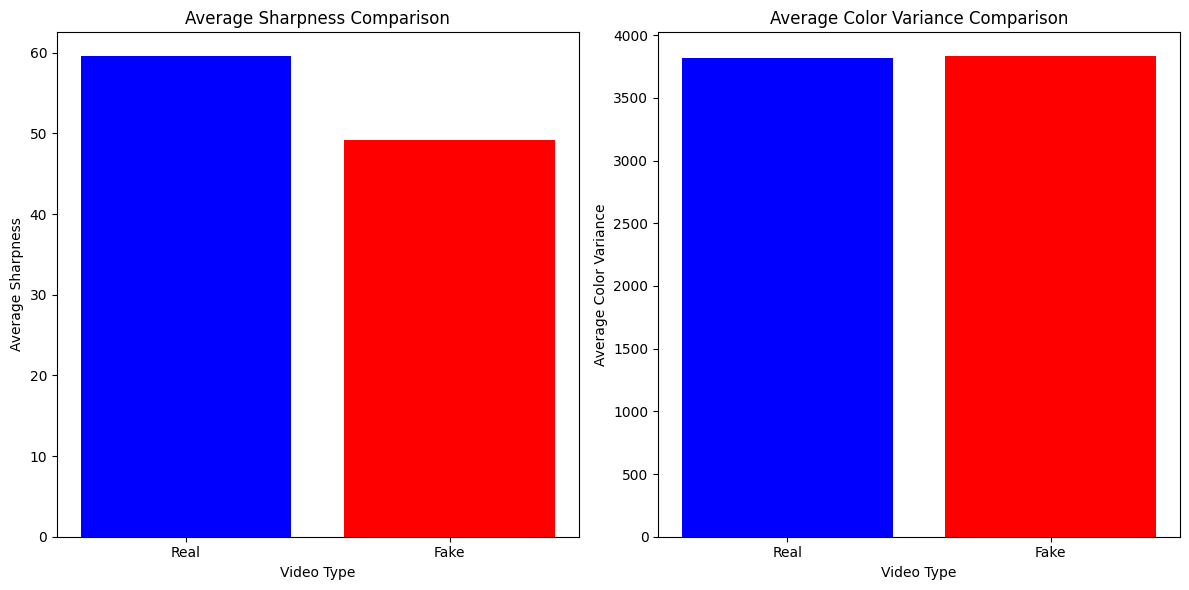

In [18]:

def calculate_sharpness_and_color_variance(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file:", video_path)
        return None, None
    
    sharpness_values = []
    color_variances = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Skip frames until we reach the 24th frame
        if frame_count % 24 != 0:
            frame_count += 1
            continue
        
        # Convert frame to grayscale for sharpness calculation
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Calculate Laplacian variance as a measure of sharpness
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        sharpness_values.append(sharpness)
        
        # Calculate color variance for each channel
        b, g, r = cv2.split(frame)
        b_var = np.var(b)
        g_var = np.var(g)
        r_var = np.var(r)
        color_variance = np.mean([b_var, g_var, r_var])
        color_variances.append(color_variance)
        
        frame_count += 1
    
    cap.release()
    
    return sharpness_values, color_variances

def process_videos_in_folder(folder_path):
    sharpness_results = []
    color_variance_results = []
    
    files = os.listdir(folder_path)
    for file in files:
        if file.endswith('.mp4'):
            video_path = os.path.join(folder_path, file)
            sharpness_values, color_variances = calculate_sharpness_and_color_variance(video_path)
            if sharpness_values is not None and color_variances is not None:
                sharpness_results.append(np.mean(sharpness_values))
                color_variance_results.append(np.mean(color_variances))
    
    return sharpness_results, color_variance_results

# Process videos in the "Real" folder
real_sharpness, real_color_variance = process_videos_in_folder('real')

# Process videos in the "Fake" folder
fake_sharpness, fake_color_variance = process_videos_in_folder('fake')

# Plotting
plt.figure(figsize=(12, 6))

# Plot average sharpness
plt.subplot(1, 2, 1)
plt.bar(['Real', 'Fake'], [np.mean(real_sharpness), np.mean(fake_sharpness)], color=['blue', 'red'])
plt.title('Average Sharpness Comparison')
plt.ylabel('Average Sharpness')
plt.xlabel('Video Type')

# Plot average color variance
plt.subplot(1, 2, 2)
plt.bar(['Real', 'Fake'], [np.mean(real_color_variance), np.mean(fake_color_variance)], color=['blue', 'red'])
plt.title('Average Color Variance Comparison')
plt.ylabel('Average Color Variance')
plt.xlabel('Video Type')

plt.tight_layout()
plt.show()


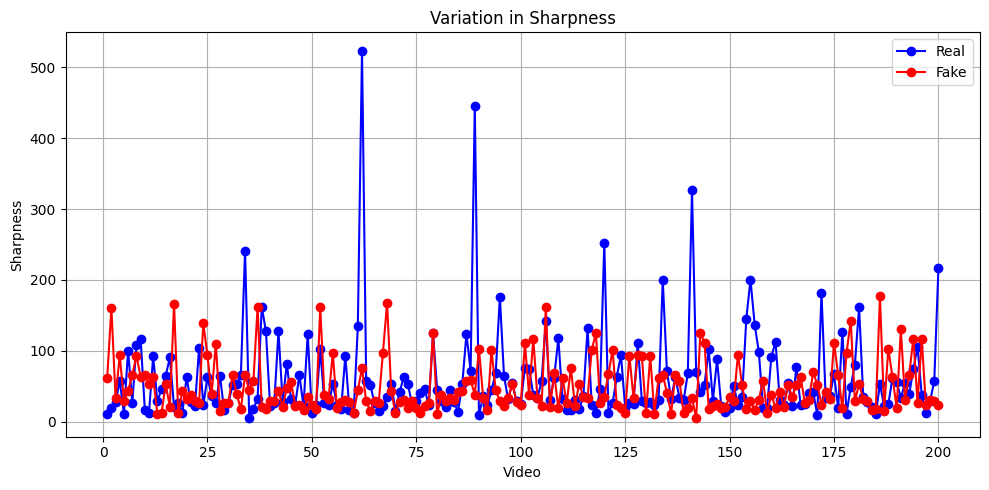

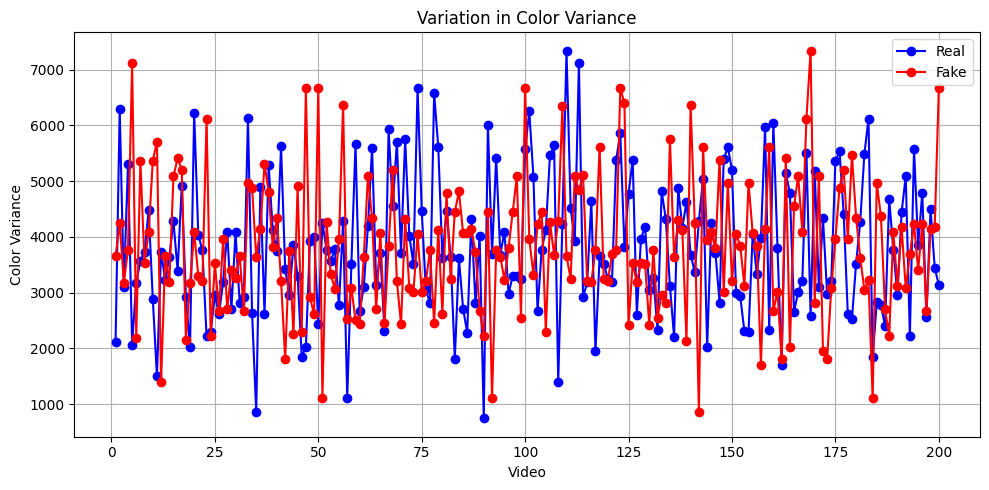

In [19]:

# Plotting variation in sharpness
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(real_sharpness) + 1), real_sharpness, marker='o', linestyle='-', color='blue', label='Real')
plt.plot(range(1, len(fake_sharpness) + 1), fake_sharpness, marker='o', linestyle='-', color='red', label='Fake')
plt.title('Variation in Sharpness')
plt.xlabel('Video')
plt.ylabel('Sharpness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting variation in color variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(real_color_variance) + 1), real_color_variance, marker='o', linestyle='-', color='blue', label='Real')
plt.plot(range(1, len(fake_color_variance) + 1), fake_color_variance, marker='o', linestyle='-', color='red', label='Fake')
plt.title('Variation in Color Variance')
plt.xlabel('Video')
plt.ylabel('Color Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
